In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Dropout,
    Dense,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D


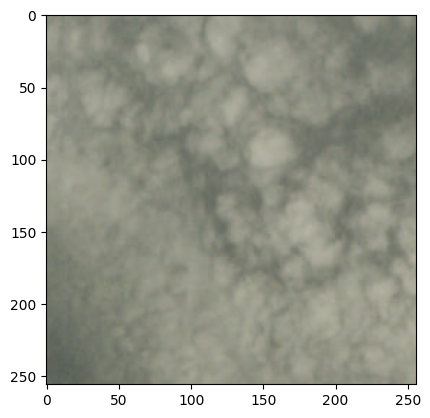

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# กำหนดโฟลเดอร์ข้อมูลหลัก
dataset_dir = Path("C:/Users/USER/Documents/GitHub/Infinite_Stratos_Project/data/star")

# กำหนดพาธสำหรับ train และ test โดยใช้ Pathlib
train_path = dataset_dir / "train"
test_path = dataset_dir / "test"

# พาธของไฟล์รูปภาพที่ต้องการเปิด
image_path = test_path / "satellite/cloudy/train_26.jpg"

# โหลดและแสดงรูปภาพ
img = load_img(image_path)

plt.imshow(img)
plt.axis("on")
plt.show()


In [5]:
img = img_to_array(img)
img.shape

(256, 256, 3)

In [6]:
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
baseModel.trainable = False


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Change the output layer to 2 classes
])
model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

c:\Users\USER\Documents\GitHub\Infinite_Stratos_Project\env_py\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,498 (96.26 MB)

 Trainable params: 25,234,498 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

Found 4505 images belonging to 1 classes.
Found 1126 images belonging to 1 classes.
Found 5631 images belonging to 1 classes.


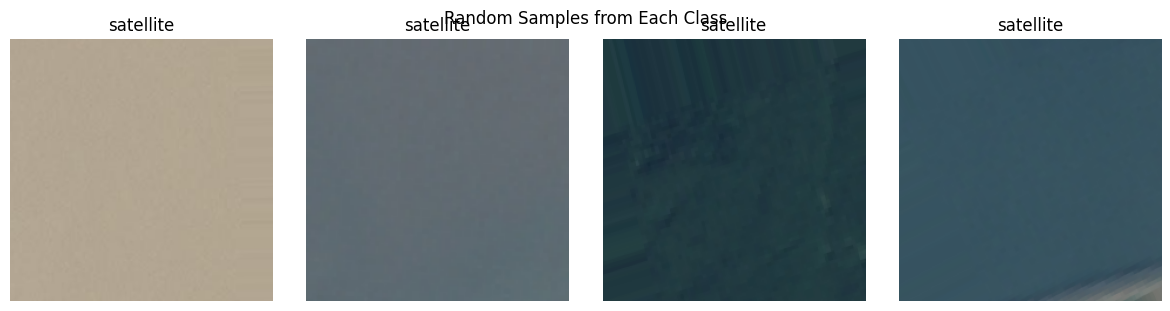

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",  # Changed to categorical
    subset="training",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",  # Changed to categorical
    subset="validation",
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to your test dataset
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",  # or "binary" depending on your setup
)
    
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)       

model.add(Dense(1, activation="sigmoid"))
model.add(Dense(2, activation="softmax"))  # For two classes (0 or 1)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

def visualize_dataset_samples(generator, num_samples=4, class_names=None):
    if class_names is None:
        class_names = list(generator.class_indices.keys())

    x_batch, y_batch = next(generator)

    n_classes = len(class_names)
    fig, axes = plt.subplots(
        n_classes, num_samples, figsize=(num_samples * 3, n_classes * 3)
    )

    for i, class_name in enumerate(class_names):
        class_idx = generator.class_indices[class_name]
        class_samples = []

        for j in range(len(y_batch)):
            if np.argmax(y_batch[j]) == class_idx:
                class_samples.append(x_batch[j])
                if len(class_samples) >= num_samples:
                    break

        while len(class_samples) < num_samples:
            x_batch, y_batch = next(generator)
            for j in range(len(y_batch)):
                if np.argmax(y_batch[j]) == class_idx:
                    class_samples.append(x_batch[j])
                    if len(class_samples) >= num_samples:
                        break

        # Plot the samples
        for j in range(num_samples):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            ax.imshow(class_samples[j])
            ax.set_title(class_name)
            ax.axis("off")

    plt.tight_layout()
    plt.suptitle("Random Samples from Each Class", y=1.02)
    plt.show()


visualize_dataset_samples(train_generator)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

In [9]:
print(train_generator.class_indices)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
)


{'satellite': 0}


c:\Users\USER\Documents\GitHub\Infinite_Stratos_Project\env_py\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.1650 - loss: 0.7382 - val_accuracy: 1.0000 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 463ms/step - accuracy: 1.0000 - loss: 0.5764 - val_accuracy: 1.0000 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 452ms/step - accuracy: 1.0000 - loss: 0.4608 - val_accuracy: 1.0000 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 459ms/step - accuracy: 1.0000 - loss: 0.3744 - val_accuracy: 1.0000 - val_loss: 0.3226 - learning_rate: 0.0010
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 454ms/step - accuracy: 1.0000 - loss: 0.3078 - val_accuracy: 1.0000 - val_loss: 0.2671 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [10]:
model.save("C:/Users/USER/Documents/GitHub/Infinite_Stratos_Project/exported_model/rf/NN/NN_save.keras")
model.save_weights("C:/Users/USER/Documents/GitHub/Infinite_Stratos_Project/exported_model/rf/NN/NN_weight.weights.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,703,517 (288.79 MB)

 Trainable params: 25,234,505 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,469,012 (192.52 MB)

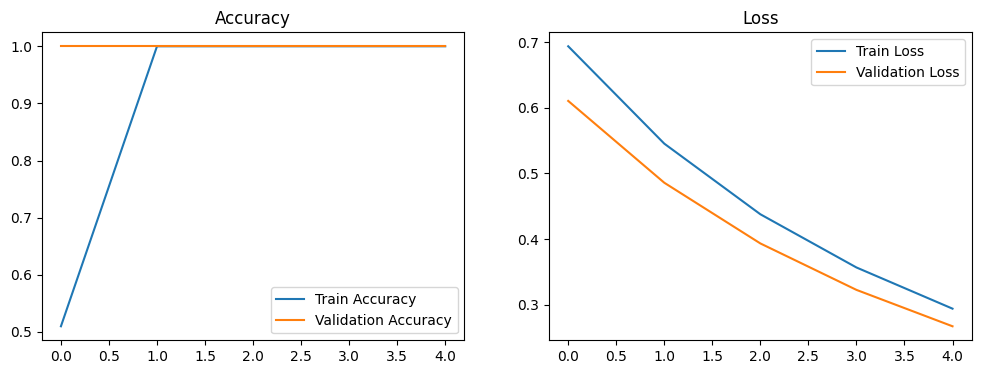

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

 21/176 ━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 1.0000 - loss: 0.2671

176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 499ms/step - accuracy: 1.0000 - loss: 0.2671
Test accuracy: 1.0000


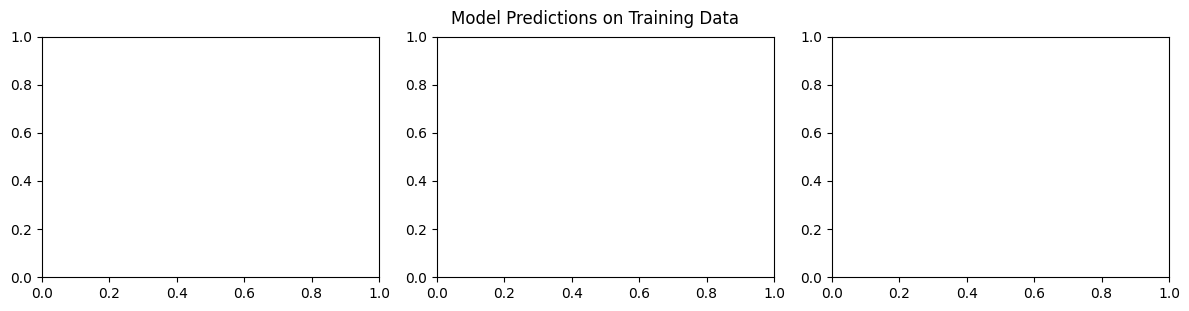

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
import random


def visualize_predictions_on_training(model, train_path, class_indices, num_samples=3):
    idx_to_class = {v: k for k, v in class_indices.items()}

    class_dirs = [
        d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))
    ]

    n_classes = len(class_dirs)
    fig, axes = plt.subplots(
        n_classes, num_samples, figsize=(num_samples * 4, n_classes * 3)
    )

    for i, class_name in enumerate(class_dirs):
        class_path = os.path.join(train_path, class_name)
        images = [
            f for f in os.listdir(class_path) if f.endswith((".jpg", ".jpeg", ".png"))
        ]

        selected_images = random.sample(images, min(num_samples, len(images)))

        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array, verbose=0)
            predicted_idx = np.argmax(prediction[0])
            predicted_class = idx_to_class[predicted_idx]
            confidence = prediction[0][predicted_idx] * 100

            title_color = "green" if predicted_class == class_name else "red"
            ax = axes[i, j]
            ax.imshow(img)
            ax.set_title(
                f"True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.1f}%",
                color=title_color,
                fontsize=10,
            )
            ax.axis("off")

    plt.tight_layout()
    plt.suptitle("Model Predictions on Training Data", y=1.02)
    plt.show()


visualize_predictions_on_training(
    model, train_path, train_generator.class_indices, num_samples=3
)

In [13]:
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you already have a model and train_generator defined
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


def predict_and_display(img_path):
    original_img, processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("on")
    plt.show()


class_dirs = [
    d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))
]

# Ensure there are subdirectories in test_path
if not class_dirs:
    print(f"No subdirectories found in the test path: {test_path}")
else:
    random_class = random.choice(class_dirs)
    class_path = os.path.join(test_path, random_class)

    # Ensure there are images in the selected class directory
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    if not images:
        print(f"No images found in class: {random_class}")
    else:
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        print(f"Testing on a random {random_class} image: {random_image}")
        predict_and_display(img_path)


No images found in class: satellite
